Submission Proyek Kedua: Membuat Model Machine Learning dengan Time Series. 

Kelas Belajar Pengembangan Machine Learning by Dicoding. 
<br>
<br>
<br>
Nama: Andi Abdul Hafez Ramadhan

Email: etchzel@gmail.com

Mount google drive ke colab

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Import library untuk pengolahan zipfile dan direktori, set direktori dasar

In [1]:
import zipfile
import os

base_dir = '/content/drive/MyDrive/Kaggle'
os.environ['KAGGLE_CONFIG_DIR'] = base_dir

Rubah working directory ke directory dasar

In [2]:
%cd "$base_dir"

/content/drive/MyDrive/Kaggle


Download dataset dari Kaggle menggunakan Kaggle API.

Token authorization untuk Kaggle API sudah terlebih dahulu diletakkan di direktori MyDrive/Kaggle.



Link dataset: https://www.kaggle.com/arashnic/learn-time-series-forecasting-from-gold-price

In [4]:
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 7.26MB/s]


In [5]:
!ls

 bbcnewsarchive
 Citrus
 covid-19-nlp-text-classification
 daily-climate-time-series-data
 imdb-synopsis-indonesian-movies
 kaggle.json
 learn-time-series-forecasting-from-gold-price.zip
 news-category-dataset
'sentiment labelled sentences'


Buat direktori untuk menyimpan dataset yang baru di download, lalu hapus zip file nya.

In [6]:
#function that creates the folder for the dataset zip file we just downloaded
def create_dataset_dir(folder_name):
  try:
    os.mkdir(folder_name)
    print('Directory ', folder_name, ' created')
  except FileExistsError:
    print('Directory ', folder_name, ' already exists!')

In [7]:
for filename in os.listdir(base_dir):
  if filename.endswith('.zip'):
    local_zip = filename
    folder_name = 'Gold-Price'
    create_dataset_dir(folder_name)

    # opening the zip file in READ mode
    with zipfile.ZipFile(local_zip, 'r') as zip:
      # printing all the contents of the zip file
      zip.printdir()
  
      # extracting all the files
      print('Extracting all the files now...')
      zip.extractall(os.path.join(
          base_dir,
          folder_name
      ))
      print('Done!')

Directory  Gold-Price  created
File Name                                             Modified             Size
gold_price_data.csv                            2020-11-19 18:52:44       190069
Extracting all the files now...
Done!


In [10]:
!rm "$local_zip"

In [3]:
os.listdir()

['kaggle.json',
 'Citrus',
 'sentiment labelled sentences',
 '.ipynb_checkpoints',
 'imdb-synopsis-indonesian-movies',
 'covid-19-nlp-text-classification',
 'news-category-dataset',
 'bbcnewsarchive',
 'daily-climate-time-series-data',
 'Gold-Price']

In [4]:
#reset variables just in case runtime dc so
#no need to go through the whole process above
folder_name = 'Gold-Price'

Ganti working directory ke folder dataset

In [5]:
%cd "$folder_name"

/content/drive/MyDrive/Kaggle/Gold-Price


Import semua Library yg dibutuhkan

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

Load dataset ke dataframe pandas, kolom Date diparsing sebagai datetime object lalu di set sebagai index dataframe

In [7]:
filename = os.listdir()[0]
filename

'gold_price_data.csv'

In [8]:
df = pd.read_csv(
    filename,
    parse_dates=['Date'],
    index_col=['Date']
)

In [9]:
df.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


Rubah nama kolom agar menjadi lebih jelas dari Value ke price_usd

In [10]:
df.rename(columns={'Value': 'price_usd'}, inplace=True)

In [11]:
df

,price_usd
Date,
1970-01-01,35.20
1970-04-01,35.10
1970-07-01,35.40
1970-10-01,36.20
1971-01-01,37.40
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


Check apakah ada missing values di dataset

In [12]:
df.isna().sum()

price_usd    0
dtype: int64

Plot dataset

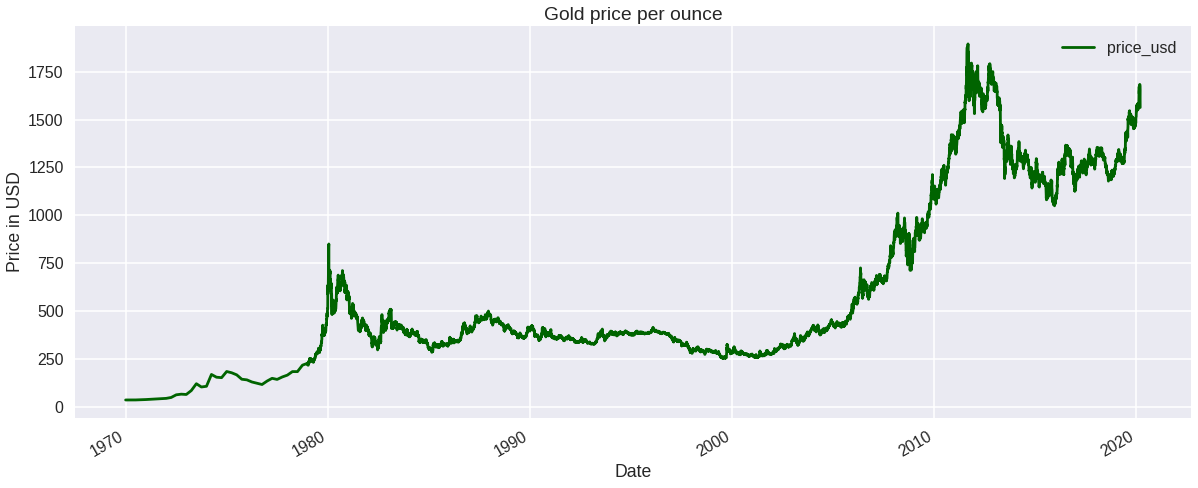

In [99]:
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')
df.plot(
    figsize=(20,8),
    title='Gold price per ounce',
    xlabel='Date',
    ylabel='Price in USD', 
    color='darkgreen'
)
plt.show()

Cari timestamp difference dari index Date untuk melihat apakah dataset sudah memiliki jarak timestamp yang sama

In [14]:
df.index.to_series().diff()

Date
1970-01-01       NaT
1970-04-01   90 days
1970-07-01   91 days
1970-10-01   92 days
1971-01-01   92 days
               ...  
2020-03-09    3 days
2020-03-10    1 days
2020-03-11    1 days
2020-03-12    1 days
2020-03-13    1 days
Name: Date, Length: 10787, dtype: timedelta64[ns]

Dapat terlihat bahwa dataset masih belum memiliki jarak timestamp yang sama.

In [15]:
df.index.to_series().diff().sum(), df.index.to_series().count()

(Timedelta('18334 days 00:00:00'), 10787)

Resample data dengan frekuensi 'Daily' untuk menyamakan jarak timestamp

In [16]:
df_resampled = df.resample('D').mean()
df_resampled

,price_usd
Date,
1970-01-01,35.20
1970-01-02,NaN
1970-01-03,NaN
1970-01-04,NaN
1970-01-05,NaN
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


Setelah proses resampling, terlihat bahwa 7548 data baru bernilai NaN telah ditambahkan ke dataset

In [100]:
print('Old sample size: {}'.format(df.shape[0]))
print('New sample size: {}'.format(df_resampled.shape[0]))
print('Newly added samples due to resampling: {}'.format(
    df_resampled.shape[0]-df.shape[0]
))

Old sample size: 10787
New sample size: 18335
Newly added samples due to resampling: 7548


Untuk menghandle missing values, digunakan fungsi interpolate dengan metode 'time' yang cocok untuk daily data sesuai dokumentasi di pandas.

In [18]:
df_cleaned = df_resampled.interpolate(method='time')

In [19]:
df_cleaned

,price_usd
Date,
1970-01-01,35.200000
1970-01-02,35.198889
1970-01-03,35.197778
1970-01-04,35.196667
1970-01-05,35.195556
...,...
2020-03-09,1672.500000
2020-03-10,1655.700000
2020-03-11,1653.750000


Plot visualisasi data resampled sebelum dan sesudah proses interpolation

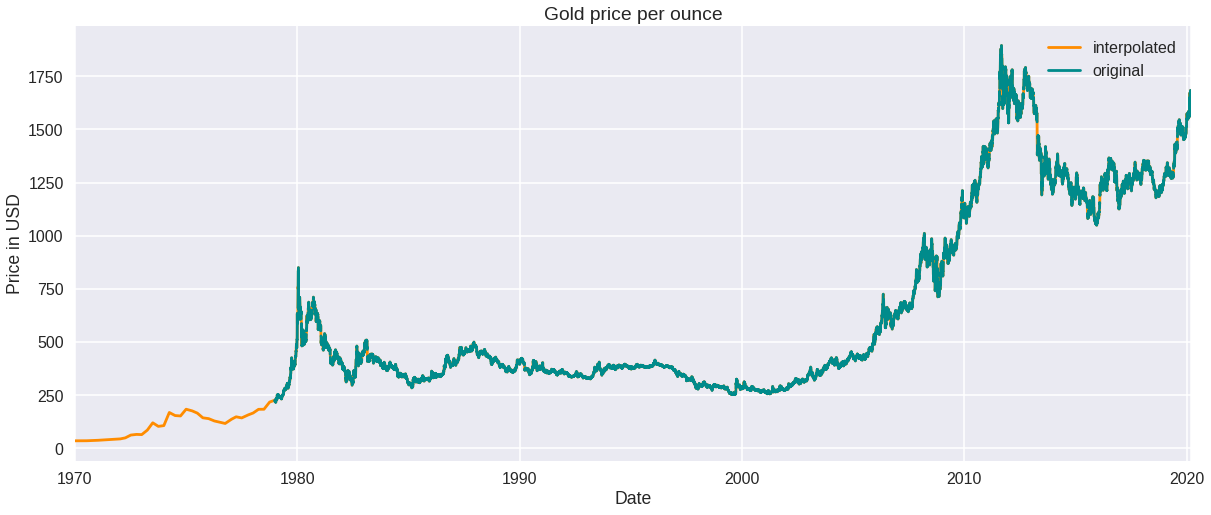

In [98]:
plt.style.use('seaborn-poster')
ax = df_cleaned.plot(
    figsize=(20,8),
    title='Gold price per ounce',
    xlabel='Date',
    ylabel='Price in USD', 
    color='darkorange'
)
df_resampled.plot(
    figsize=(20,8),
    ax=ax,
    color='darkcyan'
)
ax.legend(['interpolated', 'original'])
plt.show()

Karena range data cukup luas, data di normalisasi menggunakan MinMaxScaler

In [21]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_cleaned)

In [22]:
data_scaled

array([[5.37663315e-05],
       [5.31689278e-05],
       [5.25715242e-05],
       ...,
       [8.70288725e-01],
       [8.25635787e-01],
       [8.21388247e-01]])

Setelah proses normalisasi, data dibagi menjadi train dan validation set dimana train_size sebesar 80% total data (validation set 20%). Jumlah total sampel ada 18335 values.

In [23]:
train_size = int(data_scaled.shape[0]*0.8)
train_data = data_scaled[:train_size,:]
val_data = data_scaled[train_size:,:]

In [25]:
print('Samples: {}'.format(data_scaled.shape[0]))
print('Train samples: {}'.format(train_data.shape[0]))
print('Validation samples: {}'.format(val_data.shape[0]))

Samples: 18335
Train samples: 14668
Validation samples: 3667


class TimeseriesGenerator digunakan untuk membuat dataset agar sesuai input untuk time series machine learning.

Disini length merupakan window_size untuk dataset yang baru.
sampling_rate adalah periode timestep dalam sequence dan stride adalah periode output sequence.

In [26]:
train_gen = TimeseriesGenerator(
    data=train_data,
    targets=train_data,
    length=64,
    sampling_rate=1,
    stride=1,
    batch_size=64
)

val_gen = TimeseriesGenerator(
    data=val_data,
    targets=val_data,
    length=64,
    sampling_rate=1,
    stride=1,
    batch_size=1
)

Membuat model machine learning menggunakan class Sequential.

Layer yang digunakan adalah layer BiLSTM dan Dense sebagai hidden layer. Dropout layer digunakan untuk mengurangi overfitting

In [27]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(64,1)),
    Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [28]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-04),
    metrics=['mae']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64, 128)           33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 136,769
Trainable params: 136,769
Non-trainable params: 0
_________________________________________________________________


Custom callback class untuk memberhentikan training ketika metric validation MAE sudah tercapai baseline yang diharapkan

In [30]:
class StopOnBaseline(tf.keras.callbacks.Callback):
  def __init__(self, baseline=0.1):
    self.monitor = 'val_mae'
    self.baseline = baseline
  
  def on_epoch_end(self, epoch, logs={}):
    metric = logs.get(self.monitor)
    if metric is not None:
      if metric <= self.baseline:
        print('Baseline MAE achieved on Epoch #{}'.format(epoch+1))
        self.model.stop_training = True

Selain custom callback, callback EarlyStopping juga digunakan untuk stop training jika metric validation MAE sudah tidak ada improvement lagi dalam 5 epoch

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, verbose=1),
    StopOnBaseline(baseline=0.04)
]

In [32]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
229/229 [==============================] - 48s 164ms/step - loss: 0.0031 - mae: 0.0550 - val_loss: 0.0049 - val_mae: 0.0938
Epoch 2/50
229/229 [==============================] - 37s 162ms/step - loss: 0.0017 - mae: 0.0406 - val_loss: 0.0042 - val_mae: 0.0870
Epoch 3/50
229/229 [==============================] - 37s 161ms/step - loss: 0.0017 - mae: 0.0397 - val_loss: 0.0039 - val_mae: 0.0835
Epoch 4/50
229/229 [==============================] - 37s 161ms/step - loss: 0.0015 - mae: 0.0370 - val_loss: 0.0057 - val_mae: 0.1015
Epoch 5/50
229/229 [==============================] - 36s 160ms/step - loss: 0.0014 - mae: 0.0356 - val_loss: 4.8014e-04 - val_mae: 0.0231
Baseline MAE achieved on Epoch #5


Hasil training terlihat dimana val_mae = 0.0231 tercapai pada epoch ke 5

In [36]:
best_mae = min(history.history['val_mae'])

In [40]:
feature_range = data_scaled.max() - data_scaled.min()

best_mae_pct = (best_mae * 100)/feature_range 

MAE yang tercapai sekitar 2.31% dari skala data (Data sudah di rescale dimana range nya adalah 0 sampai 1)

In [41]:
best_mae_pct

2.3107780143618584

Buat helper function untuk plot loss dan MAE

In [104]:
def metrics_graph(history, metrics):
  val_metrics = 'val_'+metrics
  plt.plot(history.history[metrics])
  plt.plot(history.history[val_metrics])
  plt.xlabel('Epochs')
  plt.ylabel(metrics.capitalize())
  plt.title('Model '+metrics)
  plt.legend([metrics, val_metrics])
  plt.grid(True)
  plt.show()

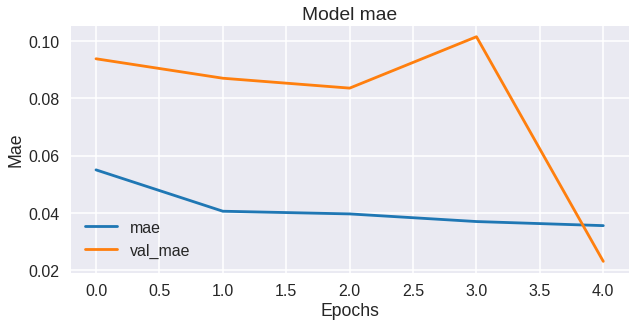

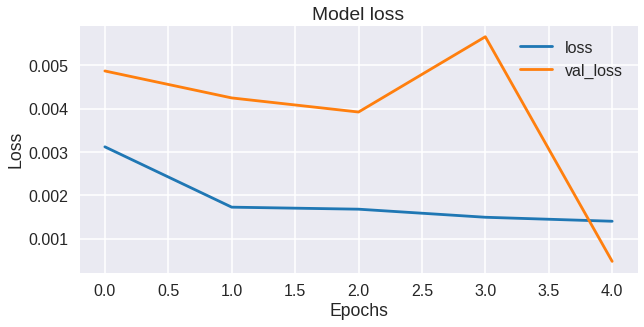

In [105]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
metrics_graph(history, 'mae')
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 2)
metrics_graph(history, 'loss')

Terakhir, mencoba forecasting menggunakan data validasi.

Pertama, buat dataframe baru menggunakan data yang sudah di rescale (data sebelumnya merupakan object numpy array bukan dataframe)

In [44]:
scaled_df = pd.DataFrame(data_scaled, index=df_cleaned.index, columns=['price_usd'])

Buat timeseries dataset dari data validasi

In [84]:
pred_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    val_data,
    val_data,
    sequence_length=64,
    sampling_rate=1,
    batch_size=1
)

Prediksi

In [86]:
pred = model.predict(
    pred_ds
)

In [87]:
pred

array([[0.591535  ],
       [0.5922061 ],
       [0.59292644],
       ...,
       [0.81262445],
       [0.81114495],
       [0.80970484]], dtype=float32)

Hasil prediksi terlihat tidak memiliki panjang yang sama dengan validasi data. Ini disebabkan oleh atribut sequence_length dari dataset yang berfungsi sebagai window size. Beberapa data terakhir sesua besar sequence_length tidak tercakup dalam prediksi

In [101]:
pred.shape, val_data.shape

((3604, 1), (3667, 1))

Buat dataframe dari hasil prediksi untuk digunakan di plot

In [95]:
pred_df = pd.DataFrame(pred, index=scaled_df.iloc[train_size:-63].index, columns=['price_usd'])
pred_df

,price_usd
Date,
2010-02-28,0.591535
2010-03-01,0.592206
2010-03-02,0.592926
2010-03-03,0.593029
2010-03-04,0.593477
...,...
2020-01-06,0.811725
2020-01-07,0.812194
2020-01-08,0.812624


Plot hasil forecast

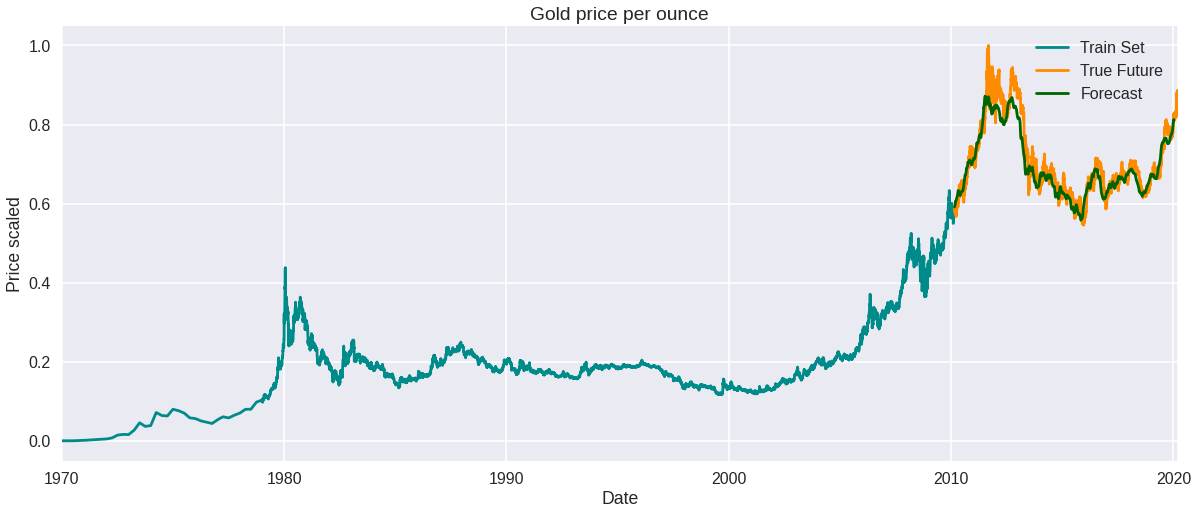

In [103]:
plt.style.use('seaborn-poster')
ax = scaled_df.iloc[:train_size].plot(
    figsize=(20,8),
    title='Gold price per ounce',
    xlabel='Date',
    ylabel='Price scaled', 
    color='darkcyan'
)

scaled_df.iloc[train_size:].plot(
    figsize=(20,8),
    ax=ax,
    color='darkorange'
)

pred_df.plot(
    figsize=(20,8),
    ax=ax,
    color='darkgreen'
)
ax.legend(['Train Set', 'True Future', 'Forecast'])
plt.show()